# U-Net On Vaihingen Dataset

Use of a U-Net model on the [Vaihingen Dataset](https://www.kaggle.com/datasets/naydex/vaihingen-cropped) : 

As a reminder, the U-Net architecture is defined as follows :

[<img src="https://camo.githubusercontent.com/41ded1456b9dbe13b8d73d8da539dac95cb8aa721ebe5fb798af732ca9f04c92/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67" alt="drawing" width="1000">](https://github.com/milesial/Pytorch-UNet)

This notebook is derived from a nice U-Net implementation in PyTorch (click the image to access it). For more information, you can take a look at the [paper](https://arxiv.org/pdf/1505.04597.pdf) !

If you are running this notebook on Google Colab, do not forget to turn on the GPU (this should make things quite faster).

In [1]:
import os
import numpy as np
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPool2D, ReLU, Input, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf

import matplotlib.pyplot as plt

2022-11-30 15:25:18.384012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## The UNet Model

You will start by defining the UNet architecture to be used for this session. As a helper, the following blocks are defined:

* `double_conv2d`: each sequence of two consecutive convolutions in the UNet model can be replaced by such a block
* `down_sampling_block`: each sequence of a down-sampling followed by a two convolutions can be replaced by such a block
* `up_sampling_block`: each sequence of an up-sampling (transposed convolution) followed by two convolutions can be replaced by such a block.

In [2]:
def double_conv2d(output_channels):
    return Sequential([
        Conv2D(filters=output_channels, kernel_size=3, padding="same", use_bias=False),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters=output_channels, kernel_size=3, padding="same", use_bias=False),
        BatchNormalization(),
        ReLU()
    ])

def down_sampling_block(output_channels):
    return Sequential([
        MaxPool2D(pool_size=2),
        double_conv2d(output_channels)
    ])

def up_sampling_block(output_channels, shape1, shape2):
    x1 = Input(shape=shape1)
    x2 = Input(shape=shape2)
    x1_up = Conv2DTranspose(output_channels, kernel_size=2, strides=2)(x1)
    
    # input is HWC
    diffY = x2.get_shape().as_list()[1] - x1_up.get_shape().as_list()[1]
    diffX = x2.get_shape().as_list()[2] - x1_up.get_shape().as_list()[2]

    x1_up = ZeroPadding2D(padding=((diffY // 2, diffY - diffY // 2), (diffX // 2, diffX - diffX // 2)))(x1_up)
    x = tf.concat([x2, x1_up], axis=-1)
    return Model(inputs=[x1, x2], outputs=double_conv2d(output_channels)(x))

**Question 1.** Using the Keras Functional API, define the UNet architecture shown above.

In [3]:
def unet_model(image_size, n_classes):
    inputs = Input(shape=image_size + (3,))
    x0 = double_conv2d(64)(inputs)
    
    x1 = down_sampling_block(128)(x0)
    x2 = down_sampling_block(256)(x1)
    x3 = down_sampling_block(512)(x2)
    x4 = down_sampling_block(1024)(x3)
    
    x = up_sampling_block(512, shape1=x4.shape[1:], shape2=x3.shape[1:])((x4, x3))
    x = up_sampling_block(256, shape1=x.shape[1:], shape2=x2.shape[1:])((x, x2))
    x = up_sampling_block(128, shape1=x.shape[1:], shape2=x1.shape[1:])((x, x1))
    x = up_sampling_block(64, shape1=x.shape[1:], shape2=x0.shape[1:])((x, x0))
    
    outputs = Conv2D(filters=n_classes, kernel_size=1, activation="softmax")(x)
    
    return Model(inputs, outputs)

In [4]:
from PIL import Image
import os

class VaihingenDataset(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, folder, small_subset=False):
        self.batch_size = batch_size
        self.input_img_paths = sorted([
            os.path.join(folder, fname)
            for fname in os.listdir(folder)
            if fname.endswith(".png")
        ])
        if small_subset:
            self.input_img_paths = self.input_img_paths[:2 * batch_size]
        self.normalization_means = np.array([0.4643, 0.3185, 0.3141])
        self.normalization_stds = np.array([0.2171, 0.1561, 0.1496])

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = []
        y = []
        for j, path in enumerate(batch_input_img_paths):
            img = Image.open(path).convert("RGB")
            x.append(np.asarray(img) / 255.)
            y.append(np.load(path.replace(".png", "_gt.npy")))
        x = np.array(x)
        y = np.array(y)
        x -= self.normalization_means[None, None, :]
        x /= self.normalization_stds[None, None, :]
        return x, y

train_loader = VaihingenDataset(batch_size=10, folder="vaihingen-cropped/vaihingen_train/", small_subset=True)
val_loader = VaihingenDataset(batch_size=10, folder="vaihingen-cropped/vaihingen_test/", small_subset=True)

In [5]:
model = unet_model(image_size=(512, 512), n_classes=6)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_loader, epochs=15, validation_data=val_loader)

2022-11-30 15:25:25.586853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
1/2 [==============>...............] - ETA: 4:12 - loss: 2.1214 - accuracy: 0.1234

## Losses

Let's define several custom losses for semantic segmentation. Note the use of the PyTorch framework and what you should do to implement your own.

In [ ]:
class SemanticCrossEntropyLoss(torch.nn.Module):
    def __init__(self, weight=None):
        """
        Parameters
        ==========
            weight: Optional[Tensor] - a manual rescaling weight given to each class. If given, has to be a Tensor of size C
        """
        super().__init__()
        self.weight = weight

    def forward(self, preds, labels):
        """
        Parameters
        ==========
            preds: Tensor - size (b, C, H, W)
            labels: Tensor - size (b, H, W)
        Returns
        =======
            ce_loss: Tensor - size () the cross entropy loss
        """
        n_classes = preds.size(1)
        preds = preds.permute(0, 2, 3, 1).reshape(-1, n_classes)
        labels = labels.flatten()
        return torch.nn.functional.cross_entropy(preds, labels, weight=self.weight)


class SemanticFocalLoss(torch.nn.Module):
    """
    Focal loss implementation from:

    - Lin, Tsung-Yi, et al. "Focal loss for dense object detection."
      Proceedings of the IEEE international conference on computer vision. 2017.
    """
    def __init__(self, gamma=0.0, weight=None):
        """
        Parameters
        ==========
            gamma : float - the regularization parameter, gamma = 0. will return the value as the SemanticCrossEntropyLoss.
            weight: Optional[Tensor] - a manual rescaling weight given to each class. If given, has to be a Tensor of size C
        """
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, preds, labels):
        """
        Parameters
        ==========
            preds: Tensor - size (b, C, H, W)
            labels: Tensor - size (b, H, W)
        Returns
        =======
            f_loss: Tensor - size () the focal loss
        """
        n_classes = preds.size(1)
        preds = preds.permute(0, 2, 3, 1).reshape(-1, n_classes)
        labels = labels.flatten()
        probs = torch.nn.functional.softmax(preds, dim=-1)
        weighted_probs = (1 - probs) ** self.gamma * probs.log()
        return torch.nn.functional.nll_loss(weighted_probs, labels, weight=self.weight)

In [ ]:
class VaihingenDataset(Dataset):
    def __init__(
        self, base_folder="output_images", transform=lambda x: x
    ) -> None:
        super().__init__()
        self.base_folder = base_folder
        self.files = [f for f in os.listdir(base_folder) if f.endswith(".png")]
        self.classes = [
            "Impervious surfaces",
            "Buildings",
            "Low vegetation",
            "Trees",
            "Cars",
            "Clutter",
            "Undefined",
        ]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_file = os.path.join(self.base_folder, self.files[index])
        gt_file = img_file.replace(".png", "_gt.npy")
        img = Image.open(img_file).convert("RGB")
        label = np.load(gt_file)

        return self.transform(img), label

In [ ]:
TRAIN_FOLDER = "vaihingen-cropped/vaihingen_train"
VAL_FOLDER = "vaihingen-cropped/vaihingen_test"

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

N_CHANNELS = 3
N_CLASSES = 7

N_EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

NORMALIZATION_MEANS = [0.4643, 0.3185, 0.3141]
NORMALIZATION_STDS = [0.2171, 0.1561, 0.1496]

In [ ]:
model = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=NORMALIZATION_MEANS, std=NORMALIZATION_STDS)
])

train_dataset = VaihingenDataset(TRAIN_FOLDER, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_dataset = VaihingenDataset(VAL_FOLDER, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)

In [ ]:
# Try other optimizers if you want !
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Here choose the loss function.
loss_fn = SemanticCrossEntropyLoss()
# loss_fn = SemanticFocalLoss(gamma=1)

losses = []
accs = []

for epoch in range(N_EPOCHS):

    epoch_losses = []

    model.train() # Setting the model in train mode i.e. activates all training layers.
    
    # Just to have a nice loading bar.
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} ")

    for images, labels in pbar:
        # Remeber to send the data to the GPU (if you are using it !).
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        masks_pred = model(images)
        loss = loss_fn(masks_pred, labels) # There was dice loss.
        
        # You know the drill.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_value = loss.cpu().item()
        
        epoch_losses.append(loss_value)
        pbar.set_description(f"Epoch {epoch}, Loss : {loss_value:.2f} ")
    
    losses.append(epoch_losses)

    model.eval()

    # Validations step.

    well_predicted = 0
    total_predicted = 0

    for images, labels in validation_loader:
        with torch.no_grad():
            preds = model(images.to(DEVICE))
    
        pred_labels = preds.argmax(dim=1)
        well_predicted += (labels.to(DEVICE) == pred_labels).sum()
        total_predicted += labels.numel()

    val_acc = well_predicted / total_predicted
    print(f"Validation Accuracy : {val_acc:2.3f}")
    accs.append(val_acc)

    torch.save(model.state_dict(), f"vaihingen_unet_epoch_{epoch:03d}.model")

Epoch 0 :   0%|          | 0/40 [00:00<?, ?it/s]

Validation Accuracy : 0.705.


Epoch 1 :   0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

You don't know what is the focal loss ? [Here](https://arxiv.org/abs/1708.02002) is the paper !

In [ ]:
# Here you can save the model for further use.
save_path = "vaihingen_unet.model"
torch.save(model.state_dict(), save_path)

: 

[Here](https://www.dropbox.com/s/sllbj3zq3gmwuyx/vaihingen_unet_ce.model?dl=0) you can find an already trained model using the Semantic Cross Entropy ! And [here](https://www.dropbox.com/s/2wgnunp1ps88ab6/vaihingen_unet_focal_loss.model?dl=0) a model trained using the focal loss !

In [ ]:
!wget https://www.dropbox.com/s/sllbj3zq3gmwuyx/vaihingen_unet_ce.model?dl=0

--2022-11-30 10:42:08--  https://www.dropbox.com/s/sllbj3zq3gmwuyx/vaihingen_unet_ce.model?dl=0
Résolution de www.dropbox.com (www.dropbox.com)… 162.125.67.18
Connexion à www.dropbox.com (www.dropbox.com)|162.125.67.18|:443… connecté.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : /s/raw/sllbj3zq3gmwuyx/vaihingen_unet_ce.model [suivant]
--2022-11-30 10:42:09--  https://www.dropbox.com/s/raw/sllbj3zq3gmwuyx/vaihingen_unet_ce.model
Réutilisation de la connexion existante à www.dropbox.com:443.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://uc79f488d9f6c388d111102684da.dl.dropboxusercontent.com/cd/0/inline/BxtM4x7_ex7n7VLGUJtgw2SnvrrRaTHtGRs96JY_n9rblQW0l2BYmst8Ux8GXCi2fa2f145HtK0RJRe1n7edrW4zXsToM5lJqUzShnj9b1x8l2JOqjutxrSRH8NiPzeegqF04kxdx6qO4kOl-r1E7mu_NnahlZCQ2HUadLJZW-0Wtg/file# [suivant]
--2022-11-30 10:42:09--  https://uc79f488d9f6c388d111102684da.dl.dropboxusercontent.com/cd/0/inline/BxtM4x7_ex7n7VLGUJtgw2SnvrrRaTHtGRs9

In [ ]:
!mv "vaihingen_unet_ce.model?dl=0" vaihingen_unet_ce.model

In [ ]:
# And you can load a model, if the parameters are the same for your loaded model instance and the saved model.
save_path = "vaihingen_unet_ce.model"
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))

<All keys matched successfully>

## Let's see the results !

In [ ]:
# The color palette to colorize pixels depending on their assigned class.

palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

In [ ]:
# Take a validation batch !

images, labels = next(iter(val_loader))

preds = model(images).argmax(axis=-1)

In [ ]:
# A bit technical.

color_preds = np.zeros((*pred_labels.shape, 3), dtype=np.float32)
gt_color_preds = np.zeros((*pred_labels.shape, 3), dtype=np.float32)

for cls, col in palette.items():
    for i in range(pred_labels.shape[0]):
        color_preds[i, pred_labels[i, :] == cls,:] = col
        gt_color_preds[i, labels[i, :] == cls,:] = col

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


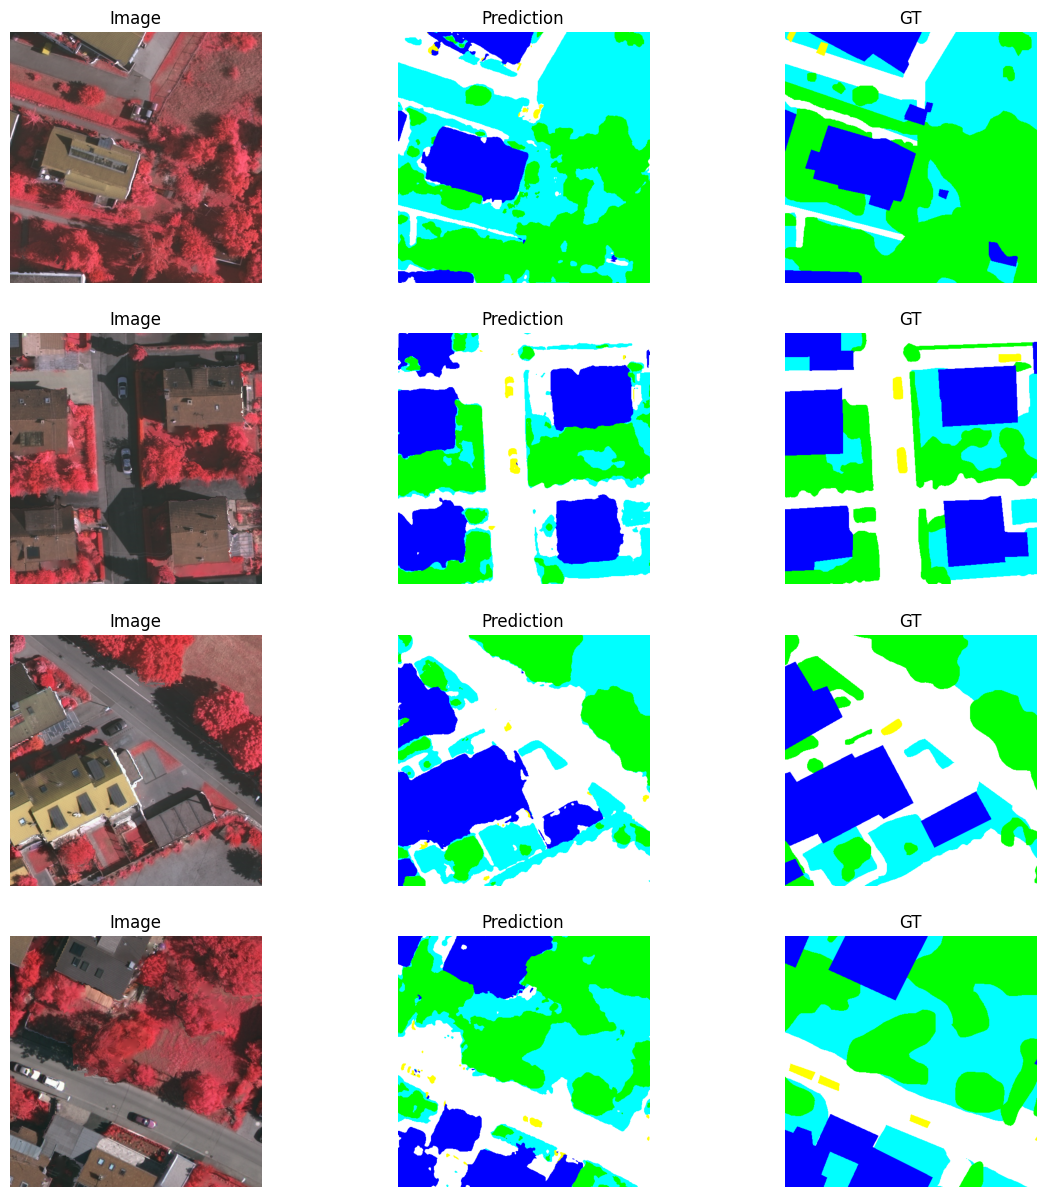

In [ ]:
# And now let's see it !

def denormalize_image(image, mean, std):
    """Denormalize the image."""
    return image * std[None, None, :] + mean[None, None, :]

fig, axes = plt.subplots(len(images), 3, figsize=(15, 15))
fig.subplots_adjust(wspace=0)

for i, (image, color_pred, gt_color_pred) in enumerate(zip(images, color_preds, gt_color_preds)):
    axes[i][0].imshow(denormalize_image(image, val_loader.normalization_means, val_loader.normalization_std))
    axes[i][0].axis('off')
    axes[i][0].set_title("Image")
    axes[i][1].imshow(color_pred)
    axes[i][1].axis('off')
    axes[i][1].set_title("Prediction")
    axes[i][2].imshow(gt_color_pred)
    axes[i][2].axis('off')
    axes[i][2].set_title("GT")

plt.axis('off')
plt.show()